## Diversity Sampling of Wikipedia Articles

This notebook provides a demo of the Coreset sampler, applied to text embeddings. 
The coreset algorithm iteratively samples the furthest texts to all the previously sampled texts, ensuring diversity.




**Notes**: We recommend running it on GPU. If you don't have access to a GPU, subsampling the data will be necessary



## Initialization

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

In [2]:
try:
    import cuml
except ImportError:
    raise ImportError('Install RAPIDS cuml to ensure DBScan is fast enough !')

In [3]:
import torch
assert torch.cuda.is_available()  # Code is faster on GPU !

In [4]:
import sys
sys.path.append('../src/')

from coreset import CoresetSampler
from plot import plot_dbscan_results, plot_coreset_results

### Retrieve data

The dataset is a preprocessed subset from [here](https://www.kaggle.com/datasets/narek1110/wikipedia-22-12-en-embeddings-all-minilm-l6-v2). 
It is available [on Kaggle](https://www.kaggle.com/datasets/theoviel/diversity-sampling-demo-data/). Make sure you have downloaded the data and put it in the `input` folder.

- **df.parquet** : contains articles & associated metadata
    - `id`: article id
    - `title`: Title of the article
    - `text`: First paragraph of the article.
    - `url`: Url of the article
    - `domain`: Predicted domain by [this 10-class](https://huggingface.co/jonaskoenig/topic_classification_04) classifier.
    - `bertopic_class`: Predict class by [BERTopic](https://huggingface.co/MaartenGr/BERTopic_Wikipedia)
- **embeds.npy** : Embeddings assoaited to the `text` column, computed using [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

In [5]:
df = pd.read_parquet('../input/df.parquet')
print(f"Retrieved {len(df)} articles")

Retrieved 486826 articles


In [6]:
df.head()

,id,title,text,url,domain,bertopic_class
0,30802348,Roman Catholic Diocese of Facatativá,The Roman Catholic Diocese of Facatativá () is a diocese located in the northwest of Cundinamarca Department in Colombia. Its see is the city of Facatativá; the diocese is part of the ecclesiastical province of Bogotá in Colombia.,https://en.wikipedia.org/wiki?curid=15894889,Society & Culture,2366_ecumenical_orthodox_catholic_ecclesiastical
1,30802349,1970 Japan Soccer League,"The 1970 season of the Japan Soccer League was the sixth season of Japanese league football. Toyo Industries won their fifth title and set the record for title wins, but they would not regain the title during the rest of the JSL's existence and would not win the successor league, the J. League Division 1, until 2012.",https://en.wikipedia.org/wiki?curid=15798791,Sports,0_goalscorer_scored_goals_goal
2,30802350,1909 Australasian Championships,"The 1909 Australasian Championships was a tennis tournament that took place on outdoor grass courts at Perth Zoo, Perth, Australia from 16 October to 25 October 1909. It was the fifth edition of the Australasian Championships (now known as the Australian Open), the first held in Perth and the third Grand Slam tournament of the year. Anthony Wilding won the singles title, his second after 1906.",https://en.wikipedia.org/wiki?curid=10978717,Sports,340_tennis_tournaments_tournament_badminton
3,30802351,Friedrich Bürklein,Georg Friedrich Christian Bürklein (30 March 1813 – 4 December 1872) was a German architect and a pupil of Friedrich von Gärtner.,https://en.wikipedia.org/wiki?curid=10690028,Education & Reference,223_nouveau_paintings_designers_façades
4,30802352,"Rodri (footballer, born 1979)","Rodrigo Gimeno Molina (born 21 September 1979), commonly known as Rodri, is a Spanish retired footballer who played mainly as a defensive midfielder.",https://en.wikipedia.org/wiki?curid=2656139,Sports,55_candidacy_candidate_candidates_presidential


In [7]:
embeds = np.load('../input/embeds.npy')
print(f"Embedding shape: {embeds.shape}")

Embedding shape: (486826, 384)


### Coreset Sampler

The class `CoresetSampler` defined in `coreset.py` does all the heavy lifting !

I also define some parameters:
- `EPS`, `MIN_SAMPLES` are DBScan initialization parameters that work well for the provided data. 
- `N_SAMPLES` is the number of points we want to sample with coreset.

In [8]:
EPS = 0.85  # Higher eps = bigger clusters
MIN_SAMPLES = 100
N_SAMPLES = 1000

In [9]:
coreset = CoresetSampler(
    n_samples=N_SAMPLES,
    initialization="dbscan",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=False,
    verbose=1,
)

### DBScan Initialization

We run DBScan clustering and analyze the results.

It takes about 1 minute to run DBScan on our data, thanks to RAPIDS cuml.

In [10]:
%%time
init_ids = coreset.initialize(embeds)

Initializing with DBScan
[W] [09:51:03.739042] Batch size limited by the chosen integer type (4 bytes). 10892 -> 4411. Using the larger integer type might result in better performance
Initialize with 36 points
CPU times: user 1min 15s, sys: 904 ms, total: 1min 16s
Wall time: 1min 16s


In [11]:
y = coreset.dbscan_y
counts = np.bincount(y + 1)

In [12]:
print('Number of clusters :', len(counts) - 1)
print('Number of non-clustered prompts :', counts[0])

Number of clusters : 36
Number of non-clustered prompts : 460123


In [13]:
biggest = np.argsort(counts[1:])[::-1] # [:10]
sizes = np.sort(counts[1:])[::-1]
print('Biggest clusters :\t', list(biggest[:10]))
print('Associated sizes :\t', list(sizes[:10]))

Biggest clusters :	 [0, 4, 10, 28, 17, 18, 5, 6, 11, 15]
Associated sizes :	 [11717, 2601, 1610, 941, 837, 734, 681, 557, 503, 458]


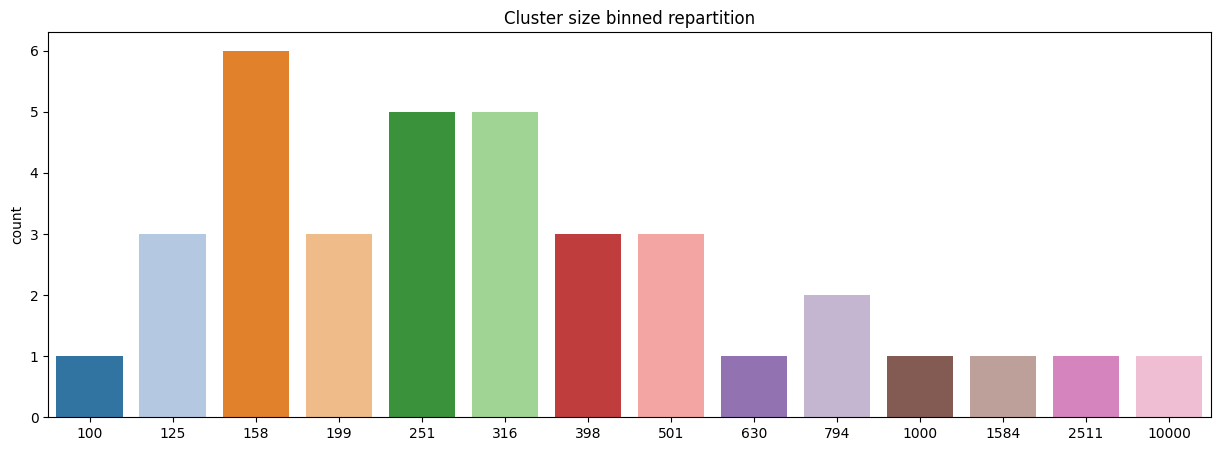

In [14]:
plt.figure(figsize=(15, 5))
sns.countplot(x=np.round(np.log10(np.clip(counts[1:], 0, 10000)), 1))
ticks, labels = plt.xticks()
labels = [float(l.get_text()) for l in labels]
plt.xticks(ticks, (10 ** np.array(labels)).astype(int))
plt.title('Cluster size binned repartition')
plt.show()

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


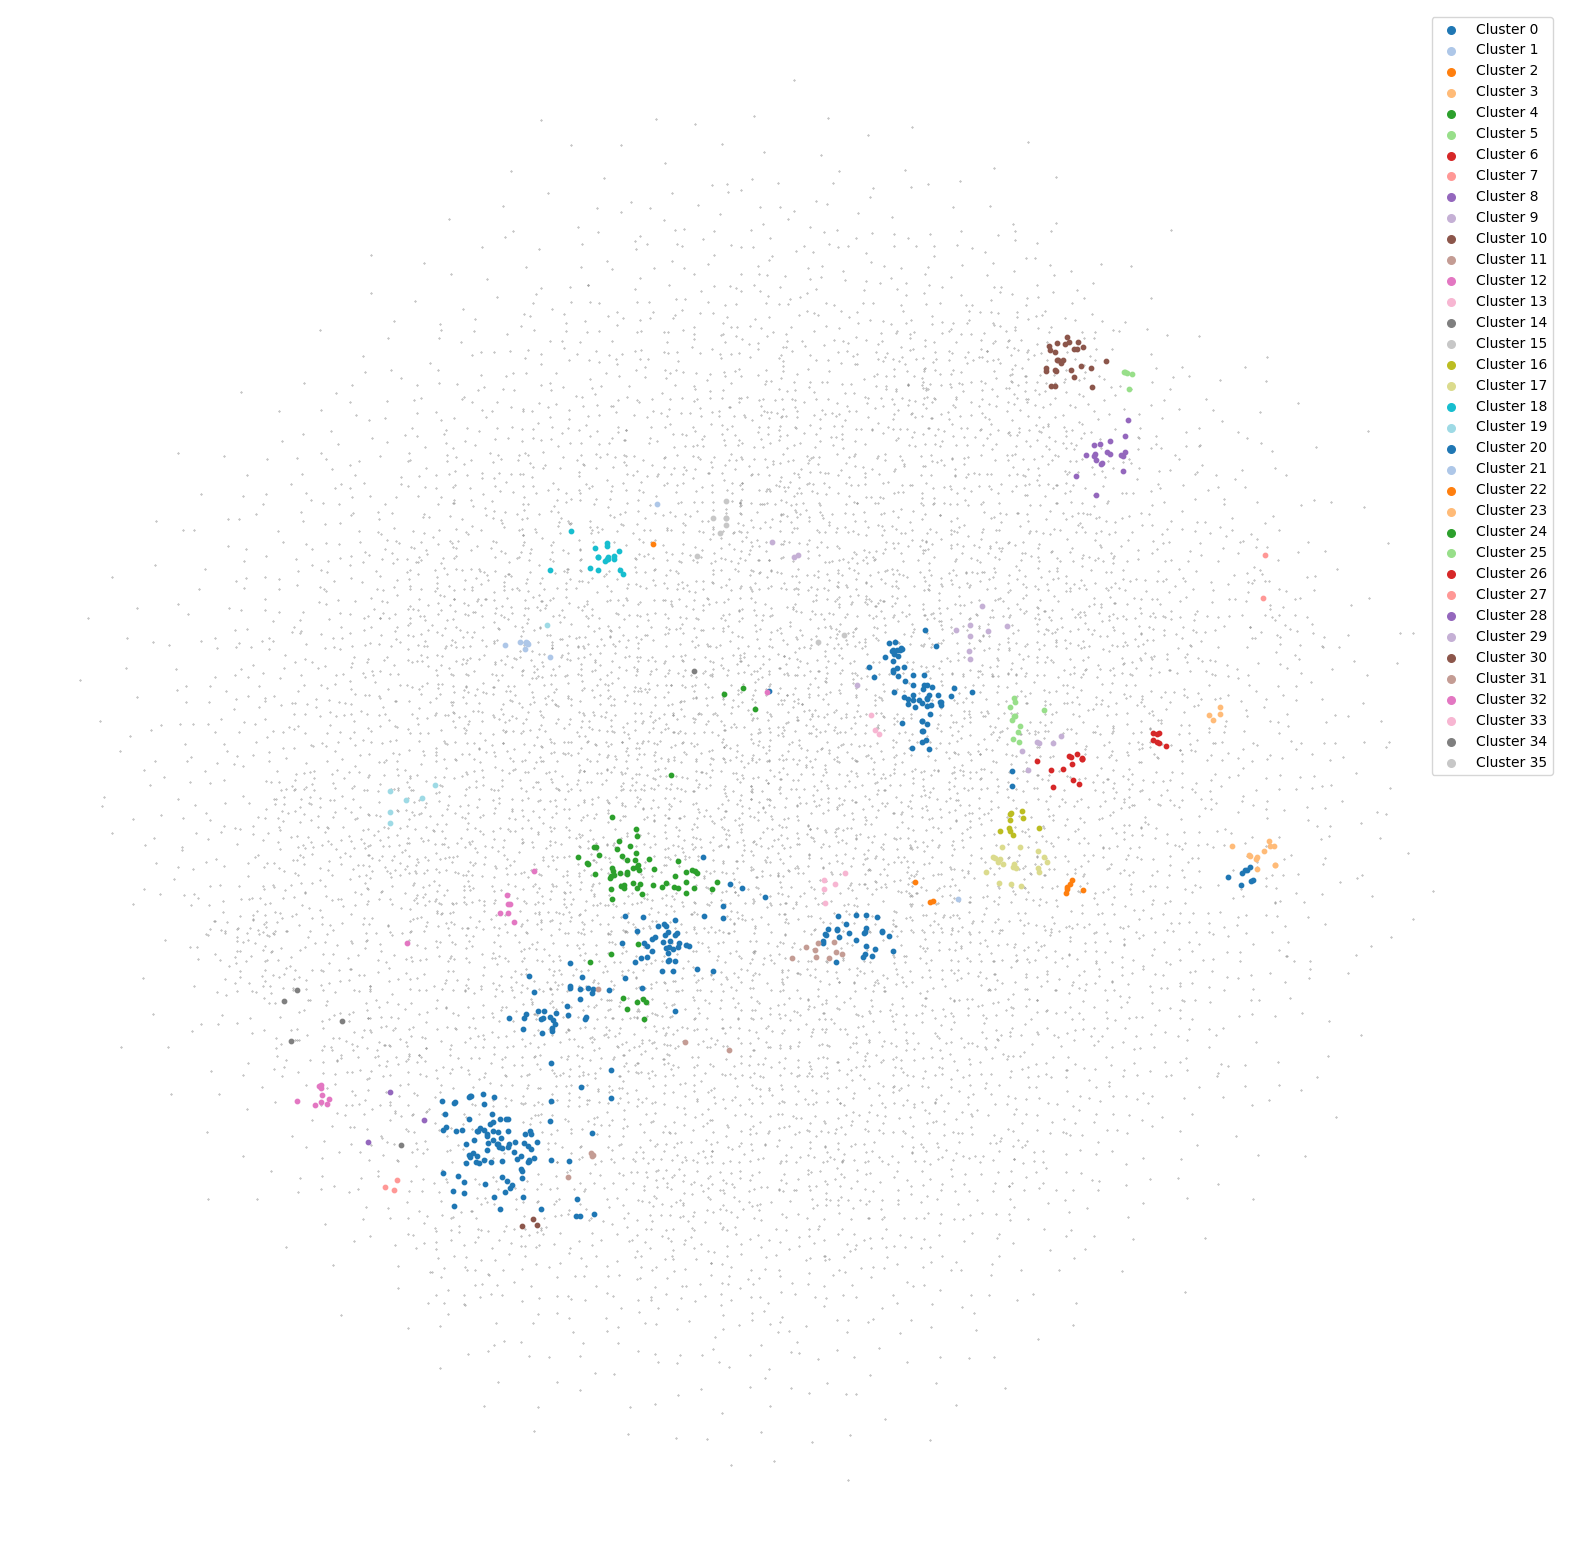

In [ ]:
plot_dbscan_results(
    embeds, 
    y,
    counts,
    min_size=MIN_SAMPLES, 
    tsne_params=dict(perplexity=10, early_exaggeration=10),
)

The `plot_dbscan_results` function uses t-SNE to visualize DBScan results. Clusters are highlighted and outliers are in gray. 
The sampler will initialize using one random point per cluster.

We display below are a sample of the 10 biggest clusters :

In [17]:
for i, l in enumerate(np.argsort(counts)[::-1][:10]):
    l -= 1
    if l == -1:
        continue
        
    if counts[l + 1] <= MIN_SAMPLES:
        continue

    ids = np.where(y == l)[0]

    print("Cluster id :", l)
    print("Cluster size :", len(ids))
    display(df[['title', 'text']].iloc[ids].sample(5))  # min(5, len(ids))))

    print('-' * 100)

    # if i > 1:
    #     break

Cluster id : 0
Cluster size : 11717


,title,text
366225,Beach volleyball at the 2002 Asian Games – Women,"The Women's Beach volleyball Tournament at the 2002 Asian Games was held from September 29 to October 4, 2002 in Busan, South Korea."
10035,Wang Zhizhen,"Wang Zhizhen (; born July 6, 1942 in Suzhou Jiangsu), also known as Chih-Chen Wang, is a Chinese biophysicist and professor at the Institute of Biophysics, Chinese Academy of Sciences. She also served as Vice Chairperson of the 11th and 12th Central Committee of the Jiusan Society and Vice Chairperson of the 12th Chinese People's Political Consultative Conference."
120486,"Kaszuba, Podlaskie Voivodeship","Kaszuba is a settlement in the administrative district of Gmina Dąbrowa Białostocka, within Sokółka County, Podlaskie Voivodeship, in north-eastern Poland."
480828,Yuchujian,"Yuchujian () was a chanyu of the Xiongnu Empire. He succeeded his brother the Northern Chanyu upon his defeat in 91 AD by the Han dynasty. Yuchujian settled at Yiwu near modern Hami and surrendered to the Han dynasty. In 93 AD, Yuchujian rebelled and fled to the north. He was convinced to return by Ren Shang and Wang Fu but died on the way back."
239742,Vladimir Sakhnov,"Vladimir Nikolaevich Sakhnov (; born April 25, 1961 in Kamenka, Tselinograd Oblast, Kazakh SSR) is a former Soviet cross-country skier who raced from 1983 to 1989. Sakhnov trained at Armed Forces sports society in Alma-Ata. He earned a silver medal in the 4 × 10 km relay at the 1988 Winter Olympics in Calgary; his best individual Winter Olympics finish was a fourth in the 30 km event in 1984."


----------------------------------------------------------------------------------------------------
Cluster id : 4
Cluster size : 2601


,title,text
147885,José Martínez (canoeist),"José Martínez (born May 7, 1973) is a Mexican sprint canoer who competed in the early 1990s. At the 1992 Summer Olympics in Barcelona, he was eliminated in the semifinals of both the C-1 1000 m and C-2 500 m events."
337288,Pedro Almeida (equestrian),"Pedro Manuel Tavares de Almeida (born 11 December 1993) is a Brazilian Olympic dressage rider. He participated at his home Olympics in Rio de Janeiro in 2016, where he placed 10th in the team and 53rd in the individual competition."
36480,Noelia Gil,Noelia Gil Pérez (born 23 May 1994) is a Spanish professional footballer who plays as a goalkeeper for Primera División club Alhama CF.
410985,"Rodri (footballer, born 2000)","Rodrigo Sánchez Rodríguez (born 16 May 2000), commonly known as Rodri (), is a Spanish professional footballer who plays for La Liga club Real Betis. Mainly an attacking midfielder, he can also play as a left winger."
265415,"Sergio Pérez (footballer, born 1997)",Sergio Pérez Jaén (born 20 June 1997) is a Spanish professional footballer who plays for CD El Ejido as a left winger.


----------------------------------------------------------------------------------------------------
Cluster id : 10
Cluster size : 1610


,title,text
121780,Ectoedemia zimbabwiensis,Ectoedemia zimbabwiensis is a moth of the family Nepticulidae. It was described by Scoble in 1983. It is known from Zimbabwe.
47546,Erebia epipsodea,"Erebia epipsodea, the common alpine, is a butterfly species of the subfamily Satyrinae of family Nymphalidae. It is found in North America from Alaska south through the Rocky Mountains to northern New Mexico and east across the prairie provinces to southwest Manitoba."
338541,Dasychira meridionalis,"Dasychira meridionalis, the southern tussock moth, is a species of tussock moth in the family Erebidae. It was first described by William Barnes and James Halliday McDunnough in 1913 and it is found in North America."
33111,Catocala semirelicta,"Catocala semirelicta, the semirelict underwing, is a moth of the family Erebidae. The species was first described by Augustus Radcliffe Grote in 1874. It is found in North America from Nevada, Colorado, Utah, California, and Nova Scotia south to Maine, west across Canada to British Columbia, and southward in the mountains."
155440,Tebenna lapidaria,Tebenna lapidaria is a moth in the family Choreutidae. It was described by Edward Meyrick in 1909. It is found in Bolivia.


----------------------------------------------------------------------------------------------------
Cluster id : 28
Cluster size : 941


,title,text
126930,Echinolittorina tricincta,"Echinolittorina tricincta is a species of sea snail, a marine gastropod mollusk in the family Littorinidae, the winkles or periwinkles."
125772,Cancellaphera amasia,"Cancellaphera amasia is a species of sea snail, a marine gastropod mollusk in the family Cancellariidae, the nutmeg snails."
47062,Cimidae,"The Cimidae is a taxonomic family of sea snails, marine gastropod mollusks in the infraclass Lower Heterobranchia."
137161,Rotaovula septemmacula,"Rotaovula septemmacula is a species of sea snail, a marine gastropod mollusk in the family Ovulidae, the ovulids, cowry allies or false cowries."
132514,Turbonilla bega,"Turbonilla bega is a species of sea snail, a marine gastropod mollusk in the family Pyramidellidae, the pyrams and their allies."


----------------------------------------------------------------------------------------------------
Cluster id : 17
Cluster size : 837


,title,text
104840,WRVW,"WRVW (107.5 FM) is a radio station licensed to the city of Lebanon, Tennessee, but serving the nearby Nashville market. It is currently branded as 107.5 The River, broadcasting a Top 40 (CHR) format, and has become something of a heritage station for Top-40 music in middle Tennessee. It is owned by iHeartMedia and operates out of studios in the world-famous ""Music Row"" area. Its transmitter is located just north of downtown Nashville."
366164,KRIG-FM,"KRIG-FM 104.9 FM is a radio station licensed to Nowata, Oklahoma. The station broadcasts a country music format and is owned by KCD Enterprises, Inc."
292886,WFTE,"WFTE (90.3 FM) was a radio station licensed to serve Mount Cobb, Pennsylvania, and (105.7 FM) Scranton, Pennsylvania The station's licensee was Community Radio Collective, Inc., a 501(c)(3) non-profit charitable organization."
319402,KBKO (FM),"KBKO (88.3 FM, ""Sacred Heart Radio"") is a radio station licensed to serve the community of Kodiak, Alaska. The station is owned by Sacred Heart Radio, Inc. It airs a Catholic radio format."
249547,WTBH,"WTBH (91.5 FM) is a radio station broadcasting a Religious music format. Licensed to Chiefland, Florida, United States. The station is currently owned by Long Pond Baptist Church."


----------------------------------------------------------------------------------------------------
Cluster id : 18
Cluster size : 734


,title,text
379087,1968 Croydon London Borough Council election,"The 1968 Croydon Council election took place on 9 May 1968 to elect members of Croydon London Borough Council in London, England. The whole council was up for election and the Conservative Party gained overall control of the council. Turnout in this election was 36.2%."
111229,2021 Essex County Council election,"Elections to Essex County Council took place on 6 May 2021 as part of the 2021 United Kingdom local elections. All 75 councillors were elected from 70 electoral divisions, with each returning either one or two councillors by first-past-the-post voting for a four-year term of office."
27806,1988 Trafford Metropolitan Borough Council election,"Elections to Trafford Borough Council in the United Kingdom were held on 5 May 1988. One-third of the council was up for election, with each successful candidate to serve a four-year term of office, expiring in 1992. The Conservative Party gained overall control of the council, from no overall control."
191706,2000 Swale Borough Council election,"The 2000 Swale Borough Council election took place on 4 May 2000 to elect members of Swale Borough Council in Kent, England. One third of the council was up for election and the council remained under no overall control."
324422,2015 Newark and Sherwood District Council election,The 2015 Newark and Sherwood District Council election took place on 7 May 2015 to elect members of the Newark and Sherwood District Council in England. It was held on the same day as other local elections.


----------------------------------------------------------------------------------------------------
Cluster id : 5
Cluster size : 681


,title,text
262154,Higashiyama Station (Hokkaido),"Higashiyama Station was served by the Hakodate Main Line, and was situated 40.1 km from the starting point of the line at . The station was numbered ""H64""."
199192,Yonezu Station,"Yonezu Station is served by the Meitetsu Nishio Line, and is located 11.6 kilometers from the starting point of the line at ."
5291,Tomizawa Station,Tomizawa Station is a terminal station on the Sendai Subway Nanboku Line and is located 14.8 rail kilometers from the opposing terminus of the line at .
337396,Hamayoshida Station,"Hamayoshida Station is served by the Jōban Line, and is located 329.6 kilometers from the official starting point of the line at in Tokyo."
481,Shinkanaoka Station,"Shinkanaoka Station is served by the Midōsuji Line, and is 23.0 kilometers from the terminus of the line at and 28.9 kilometers from ."


----------------------------------------------------------------------------------------------------
Cluster id : 6
Cluster size : 557


,title,text
196023,Hatkachora,"India census, Hatkachora had a population of 6054. Males constitute 51% of the population and females 49%. Hatkachora has an average literacy rate of 64%, higher than the national average of 59.5%: male literacy is 72%, and female literacy is 56%. In Hatkachora, 13% of the population is under 6 years of age."
463139,"Shintomi, Miyazaki","As of October 1, 2019, the town has an estimated population of 16,663 and the density of 271 persons per km². The total area is 61.53 km²."
446144,Daitari,"India census, Daitari had a population of 4239. Males constitute 54% of the population and females 46%. Daitari has an average literacy rate of 69%, higher than the national average of 59.5%: male literacy is 78% and, female literacy is 60%. In Daitari, 11% of the population is under 6 years of age."
244388,"Nariwa, Okayama","As of 2003, the town had an estimated population of 5,593 and a density of 68.32 persons per km. The total area was 81.87 km."
331670,Bakiabad,"India census, Bakiabad had a population of 3979. Males constitute 53% of the population and females 47%. Bakiabad has an average literacy rate of 71%, higher than the national average of 59.5%; with 60% of the males and 40% of females literate. 11% of the population is under 6 years of age."


----------------------------------------------------------------------------------------------------
Cluster id : 11
Cluster size : 503


,title,text
148632,Park Seong-tae,Park Seong-tae (born 10 July 1927) is a South Korean former sports shooter. He competed in the skeet event at the 1972 Summer Olympics.
139059,Kim Yun-ji,"Kim Yun-ji (; born January 16, 2000) is a South Korean handball player currently playing for Samcheok City of the Handball Korea League. She competed in the 2020 Summer Olympics."
14874,Jang Yoon-jung,"Jang Yoon-jung (born 11 June 1966) is a South Korean former taekwondo practitioner. She won the silver medal at the 1988 Summer Olympics, where taekwondo was a demonstration sport, in the heavyweight event. At the 1988 Asian Taekwondo Championships she became Asian Champion in the heavyweight category."
268824,Kim Jung-hyop,"Kim Jung-hyop (, born 1938) is a North Korean politician. He is a member of the Central Committee of the Workers' Party of Korea, head of the Party's Office of Documents and served as a member of the 13th convocation of the Supreme People's Assembly and director of the Documents Management Office of the Central Committee."
129864,Lee Kang-won,Lee Kang-Won (Hangul: 이강원; born 5 May 1990) is a South Korean male volleyball player. He is part of the South Korea men's national volleyball team. On club level he plays for the Daejeon Samsung Fire Bluefangs.


----------------------------------------------------------------------------------------------------


### Sampling

Apply the coreset algorithm, and show the results with t-SNE !

In [19]:
ids = coreset.sample(embeds)

Use previously computed dbscan_y
Initialize with 36 points


100%|██████████| 964/964 [00:04<00:00, 194.95it/s]


[W] [09:57:24.797457] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


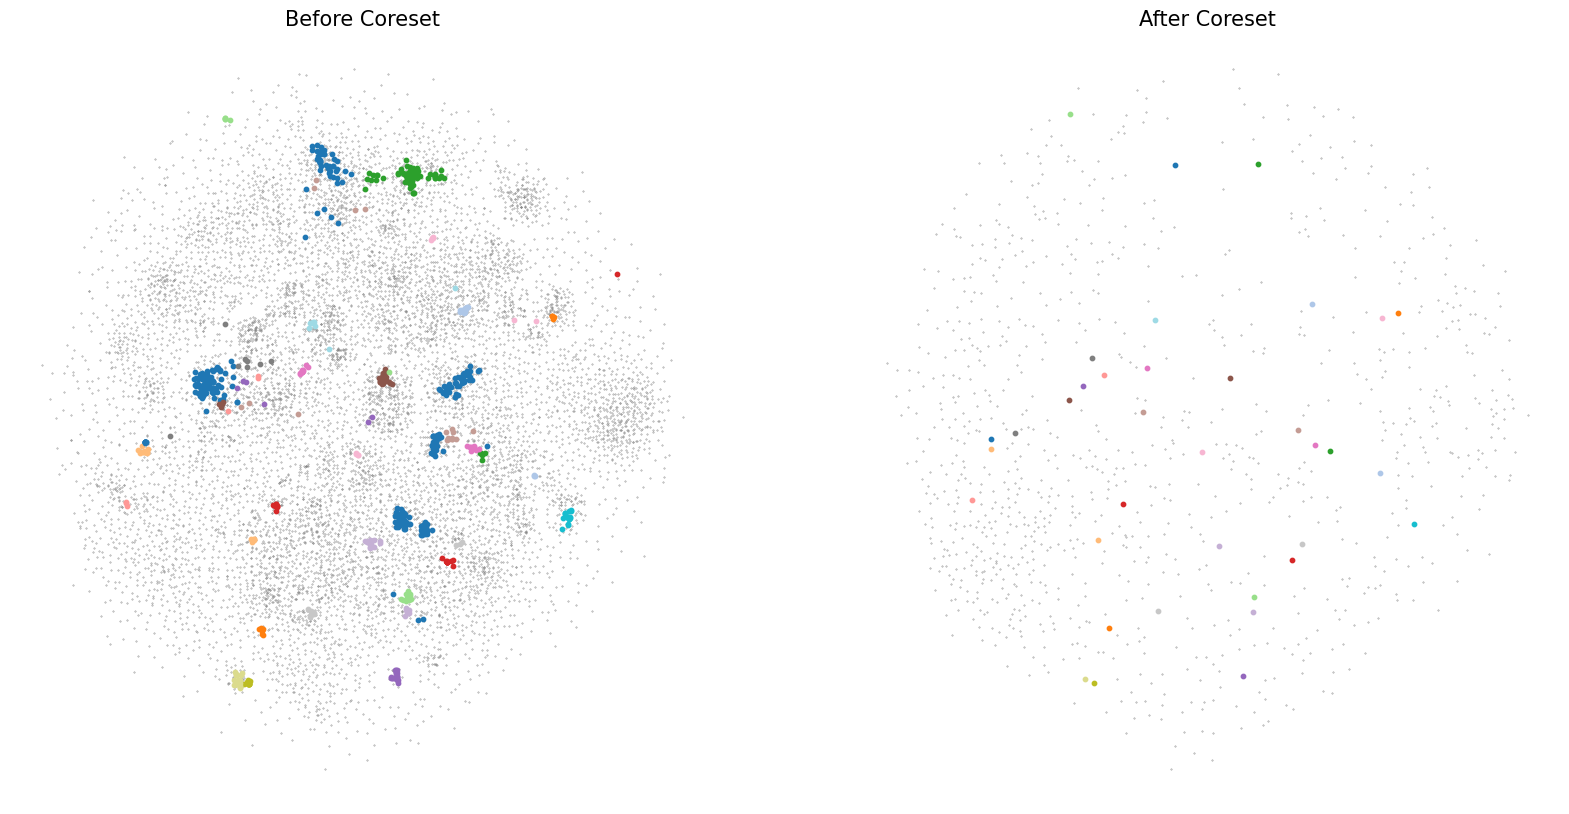

In [20]:
plot_coreset_results(
    embeds,
    y,
    counts,
    ids,
    min_size=MIN_SAMPLES,
    tsne_params=dict(perplexity=50, early_exaggeration=200),
)

## Compare with Random Sampling

To assess performance of the sampler, we provide two metrics that aim at demonstrating that the sampled data is more diverse than what you would get using random sampling.
The run the algorithm several times for more robustness, and do not use any initialization to save time.

- **Diversity**: We count the number of topics the sampled data contains and normalize it by its size. A higher value is better. The provided BERTopic classifier takes 2374 different values on our data.
- **KL Divergence**: Using a 10-class domain classifier, we aim at having a uniform sampling. This is assessed using the Kullback-Leibler divergence of the distribution of the sampled classes from the uniform distribution. A lower value is better.

In [21]:
N_TEXTS = [100, 500, 1000, 2000, 3000, 4000, 5000]  # Number of texts to sample

In [22]:
coreset = CoresetSampler(
    initialization="",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=True,
    verbose=0,
)

In [23]:
diversities_coreset = []
kl_divs_coreset = []
for n in N_TEXTS:
    diversities, kl_divs = [], []
    for _ in range(3):  # 3 -> 1 for faster execution
        sampled_ids = coreset.sample(embeds, n_samples=n)
        df_s = df.iloc[sampled_ids].reset_index(drop=True)
        
        # Diversity
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)

        # KL Div
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_coreset.append(div)
    kl_divs_coreset.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  -  KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.980  -  KL Divergence 0.230
- n=500 	-  Diversity: 0.862  -  KL Divergence 0.242
- n=1000 	-  Diversity: 0.735  -  KL Divergence 0.287
- n=2000 	-  Diversity: 0.582  -  KL Divergence 0.297
- n=3000 	-  Diversity: 0.484  -  KL Divergence 0.307
- n=4000 	-  Diversity: 0.415  -  KL Divergence 0.302
- n=5000 	-  Diversity: 0.359  -  KL Divergence 0.319


In [24]:
diversities_random = []
kl_divs_random = []
for n in N_TEXTS:
    diversities = []
    kl_divs = []
    for _ in range(10):
        df_s = df.sample(n).reset_index(drop=True)
        
        # Diversity
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)
                
        # KL Div
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_random.append(div)
    kl_divs_random.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  - KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.889  - KL Divergence 0.293
- n=500 	-  Diversity: 0.669  - KL Divergence 0.381
- n=1000 	-  Diversity: 0.545  - KL Divergence 0.378
- n=2000 	-  Diversity: 0.412  - KL Divergence 0.420
- n=3000 	-  Diversity: 0.338  - KL Divergence 0.452
- n=4000 	-  Diversity: 0.291  - KL Divergence 0.461
- n=5000 	-  Diversity: 0.259  - KL Divergence 0.444


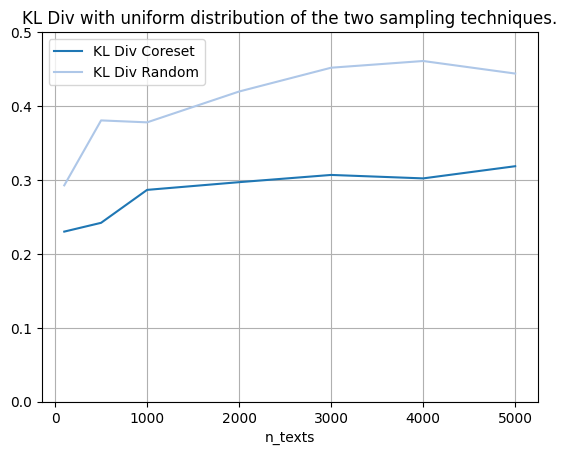

In [25]:
plt.plot(N_TEXTS, kl_divs_coreset, label="KL Div Coreset")
plt.plot(N_TEXTS, kl_divs_random, label="KL Div Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 0.5)
plt.grid()
plt.title('KL Div with uniform distribution of the two sampling techniques.')
plt.show()

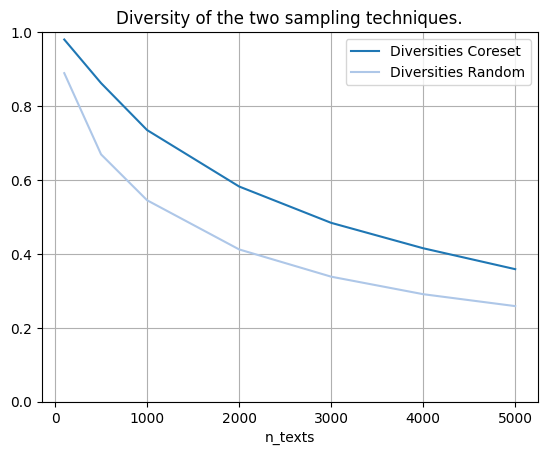

In [26]:
plt.plot(N_TEXTS, diversities_coreset, label="Diversities Coreset")
plt.plot(N_TEXTS, diversities_random, label="Diversities Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 1)
plt.grid()
plt.title('Diversity of the two sampling techniques.')
plt.show()

The metrics show that the sampled texts better captures the diversity of our dataset than random sampling, and are less biased by topic imbalance.

This is useful if your goal is to use a subset of wikipedia articles to finetune models.
A dataset sampled with coreset will provide more robustness for evaluation and more diversity of training.